### Setting up Google Colab Environment

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
!kaggle datasets download -d sanjeetsinghnaik/used-car-information

Dataset URL: https://www.kaggle.com/datasets/sanjeetsinghnaik/used-car-information
License(s): CC0-1.0
  0% 0.00/176k [00:00<?, ?B/s]
100% 176k/176k [00:00<00:00, 291MB/s]


In [4]:
!unzip used-car-information.zip

Archive:  used-car-information.zip
  inflating: Dataset.csv             
  inflating: UsedCars_Banglore.csv   
  inflating: UsedCars_Chennai.csv    
  inflating: UsedCars_Combined.csv   
  inflating: UsedCars_Delhi.csv      
  inflating: UsedCars_Hyderabad.csv  
  inflating: UsedCars_Kolkata.csv    
  inflating: UsedCars_Mumbai.csv     
  inflating: UsedCars_Pune.csv       


### Reading the CSV

There are some columns which cannot be meaningfully used in linear regression. Those are columns that have unique text values (and nothing consistent can be extracted from them), or columns with unique identifier. Such columns will be removed from the dataset.

In [5]:
import pandas as pd

cars_df = pd.read_csv("Dataset.csv")
print(cars_df.describe())

        Unnamed: 0           Id         year         price  \
count  1725.000000  1725.000000  1725.000000  1.725000e+03   
mean    862.000000   862.000000  2015.390725  1.494837e+06   
std     498.108924   498.108924     3.207504  1.671658e+06   
min       0.000000     0.000000  1990.000000  6.250000e+04   
25%     431.000000   431.000000  2013.000000  5.450000e+05   
50%     862.000000   862.000000  2016.000000  8.750000e+05   
75%    1293.000000  1293.000000  2018.000000  1.825000e+06   
max    1724.000000  1724.000000  2021.000000  1.470000e+07   

       distance_travelled(kms)   brand_rank      car_age  \
count              1725.000000  1725.000000  1725.000000   
mean              53848.256232    15.731014     5.609275   
std               44725.541963    12.951122     3.207504   
min                 350.000000     1.000000     0.000000   
25%               29000.000000     5.000000     3.000000   
50%               49000.000000    14.000000     5.000000   
75%               705

### Removing unnecessary columns

`Id` is a unique identified for each value.

`full_model_name` consists of mostly unique value for each car. Meaningful features, like year of the car of brand name are already extracted in corresponding columns, so there is no point keeping it in context of linear regression.

Same for `model_name`

`std_invprice` and `inv_car_price` create a leakage of target column in the dataset, so they should be removed.

In [6]:
columns_to_remove = ["Id", "full_model_name", "model_name", "inv_car_price", "std_invprice"]

# There is an unnamed column so it should be removed by index

clean_df = cars_df.drop(cars_df.columns[0], axis=1).drop(columns=columns_to_remove)

print(clean_df.columns)

Index(['year', 'brand', 'price', 'distance_travelled(kms)', 'fuel_type',
       'city', 'brand_rank', 'car_age', 'distance below 30k km',
       'new and less used', 'inv_car_dist', 'inv_car_age', 'inv_brand',
       'std_invdistance_travelled', 'std_invrank', 'best_buy1', 'best_buy2'],
      dtype='object')


First, I want to know how many different labels there are in the brand and city columns. If there are not too many, then we can use one-hot encoding.

*In retrospect, one-hot encoding is safe for linear regression, since most of the values would be 0, which mathematically reduces those columns and does not cause any "curse of dimensionality" problems.

** In next retrospect, one-hot encoding is not a good encoding for this dataset, since the amount of brands is quite large and the dataset does not contain enough rows for linear regression to find the correlation.

In [7]:
columns_to_count = ["brand", "city"]

for col in columns_to_count:
  print(clean_df[col].value_counts())
  print("\n")

brand
Hyundai             297
Maruti Suzuki       275
Honda               153
Mercedes-Benz       131
Toyota              117
BMW                 111
Audi                 98
Mahindra             93
Ford                 78
Volkswagen           70
Renault              51
Skoda                45
Tata                 44
Jaguar               30
Land Rover           28
Volvo                17
Nissan               13
Kia                  12
MINI                 10
Jeep                 10
MG                   10
Chevrolet             9
Porsche               5
Mitsubishi            4
Bentley               3
Datsun                3
Lamborghini           2
Lexus                 2
Fiat                  2
Isuzu                 1
Mahindra-Renault      1
Name: count, dtype: int64


city
Chennai        493
Bangalore      247
Pune           247
Hyderabad      245
Delhi          187
Mumbai         165
Dehradun        56
Thane           48
Noida           12
Ghaziabad       10
Lucknow          6
Navi Mum

### Categorical Brand Split

There are too many distinct brand values and too few dataset rows to use one-hot encoding. Because of that, I split brand column into three categories: economy, standard and premium.

It might look like splitting brands into subcategories creates data leakage of target column (price). However, that is not the case, since the split is done based on external domain knowledge, not on prices from the dataset itself, so it is fine.

In [8]:
economy_brands = [
    "Maruti Suzuki",
    "Hyundai",
    "Tata",
    "Mahindra",
    "Renault",
    "Ford",
    "Datsun",
    "Fiat",
    "Isuzu"
]

standard_brands = [
    "Honda",
    "Toyota",
    "Volkswagen",
    "Skoda",
    "Nissan",
    "Kia",
    "MG",
    "Chevrolet",
    "Mitsubishi"
]

premium_brands = [
    "BMW",
    "Mercedes-Benz",
    "Audi",
    "Jaguar",
    "Land Rover",
    "Volvo",
    "MINI",
    "Jeep",
    "Porsche",
    "Lexus",
    "Bentley",
    "Lamborghini",
    "Mahindra-Renault"
]


Now I will split these brands into three categories: economy, standard and premium.

Initially, I wanted to create a column for each brand. I got the following correlation results:

```
economy                     -0.390924
standard                    -0.170926
premium                      0.614698
```

However, after that I tried another approach, which yielded an overall better result (will explain my view of "better" in later section)

In [109]:
clean_df["economy"] = clean_df["brand"].isin(economy_brands).astype(int)
clean_df["standard"] = clean_df["brand"].isin(standard_brands).astype(int)
clean_df["premium"] = clean_df["brand"].isin(premium_brands).astype(int)

In [111]:
clean_df = clean_df.drop(columns=["economy", "standard", "premium"])

In [110]:
columns_to_count = ["economy", "standard", "premium"]
for col in columns_to_count:
  print("Value counts:")
  print(clean_df[col].value_counts())
  print("\n")
  print("Percentage from total dataset:")
  print(clean_df[col].value_counts().filter(like="1", axis=0) / len(clean_df))
  print("\n")

Value counts:
economy
0    881
1    844
Name: count, dtype: int64


Percentage from total dataset:
economy
1    0.489275
Name: count, dtype: float64


Value counts:
standard
0    1292
1     433
Name: count, dtype: int64


Percentage from total dataset:
standard
1    0.251014
Name: count, dtype: float64


Value counts:
premium
0    1277
1     448
Name: count, dtype: int64


Percentage from total dataset:
premium
1    0.25971
Name: count, dtype: float64




I created another column `brand_tier`, which has values of:

- 1, if brand is economy
- 2, if brand is standard
- 3, if brand is premium

This column has a good correlation rate of 0.557198.

Having `brand_tier` column is better than having separate column for each brand category, since OneDimension is better than ThreeDimensions (OneDirection reference), and the previous `standard` and `economy` columns have a quite small correlation rate, even though `premium` column had a higher correlation rate than `brand_tier`.

I thought that correlation rate should also be considered in the context of weighted average of brand category distribution, meaning that I calculated the sum of correlations times their percentage of the dataset. In pseudocode, that would be
```
weighted_average = sum(correlation * (brand.count_of_ones / brand.total) for brand in brand_tier)
```

The weighted average was 0.393817376644. In retrospect, this value is actually meaningless. Of course, it is good for a column to have reasonable distribution of values (e.g. 1% of 0s and 99% of 1s), but if the column does not offer significant insight to the price, then the column has a smaller correlation value.

In [13]:
brand_tier_map = {
    **{b: 1 for b in economy_brands},
    **{b: 2 for b in standard_brands},
    **{b: 3 for b in premium_brands},
}

clean_df["brand_tier"] = clean_df["brand"].map(brand_tier_map)

Then, I tried creating a similar encoding for the cities based on population. Resulting `city_tier` column did not yield a good result on the same level as `brand_tier`, but it is still better than having it all in string values.

In [14]:
large_cities = [
    "Delhi",
    "Mumbai",
    "Bangalore",
    "Chennai",
    "Hyderabad",
    "Pune"
]

medium_cities = [
    "Noida",
    "Ghaziabad",
    "Thane",
    "Navi Mumbai",
    "Dehradun"
]

small_cities = [
    "Lucknow",
    "Faridabad",
    "Agra",
    "Panchkula"
]

In [15]:
city_tier_map = {
    **{c: 3 for c in large_cities},
    **{c: 2 for c in medium_cities},
    **{c: 1 for c in small_cities},
}

clean_df["city_tier"] = clean_df["city"].map(city_tier_map)


### Data Preprocessing

As a responsible data engineer, I will normalize and fix skewed data columns to get a better performance out of linear regression model. All columns are mapped onto [0, 1] range to provide better gradient descent performance.

In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

categorical_columns = ["fuel_type"]
def preprocess_df(df, save=False):
  # One-hot encode categorical columns
  df = pd.get_dummies(df, columns=categorical_columns, drop_first=False, dtype=int)

  # Apply log transform to fix right-skewed distros
  right_skewed = ["price", "distance_travelled(kms)", "brand_rank", "car_age",
                  'distance below 30k km', 'new and less used',
                  'inv_car_dist', 'inv_car_age', 'inv_brand', 'brand_tier']
  df[right_skewed] = np.log1p(df[right_skewed])

  # Normalize numerical columns (0 - 1)
  num_cols = ["car_age", "brand_rank", "best_buy1", "best_buy2", "year",
              "price", "distance_travelled(kms)", "distance below 30k km",
              "new and less used", "brand_tier"]
  scaler = MinMaxScaler()
  df[num_cols] = scaler.fit_transform(df[num_cols])

  return df

dataset = preprocess_df(clean_df)


### Correlation Heatmap

I made a correlation heatmap to see how columns pairwise correlate to each other. Obviously, the main diagonal has full correlation and inverse values are the opposite of the original values. I also print to the console the correlations specifically to the `price` column.

Correlation of dataset columns to price:
year                         0.438126
price                        1.000000
distance_travelled(kms)     -0.201917
brand_rank                  -0.309293
car_age                     -0.425958
distance below 30k km        0.209160
new and less used            0.264854
inv_car_dist                 0.093498
inv_car_age                  0.367901
inv_brand                    0.276092
std_invdistance_travelled    0.093441
std_invrank                  0.252386
best_buy1                   -0.109135
best_buy2                    0.052341
brand_tier                   0.602731
city_tier                   -0.095746
Name: price, dtype: float64


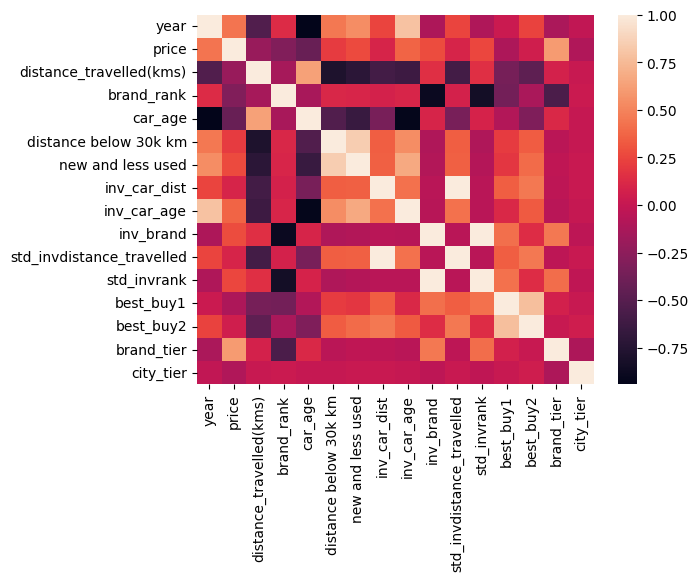

In [67]:
import seaborn

# Hiding categorical columns, since their correlation is low
# They overflow the heatmap and make it hard to see values of other columns
cat_cols_with_postfix = tuple(f"{col}_" for col in categorical_columns)
df_filtered = dataset.loc[:, ~dataset.columns.str.startswith(cat_cols_with_postfix)]
corr = df_filtered.corr(numeric_only=True)
seaborn.heatmap(corr)

print("Correlation of dataset columns to price:")
print(corr["price"])

### Variance Inflation Factor (VIF) Analysis

Below I analyzed the Variance Inflation Factor (VIF) between several columns. After analyzing the results, it looks like some columns have very high VIFs relative to other ones.

For example, diesel and petrol cars seem to be highly correlated to the year. Even though no research suggests that, high VIFs means that the columns are highly related, hence these columns have to be PCAed or combined to avoid multicollinearity.

Usually, high VIF columns add noise to the dataset and degrade the performance of linear regression models. However, in my case, leaving these `fuel_type` columns improved the performance of the models.

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Inverse columns will show a infinite variation, since they are directly
# correlated to the original columns
inv_columns = [col for col in dataset.columns if col.startswith('inv_')]
# X = dataset.copy().drop(columns=["brand", "city", "car_age"] + inv_columns)
X = dataset[[col for col in dataset.columns if col.startswith('fuel_')] + ["year"]]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

/tmp/ipython-input-1209833172.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


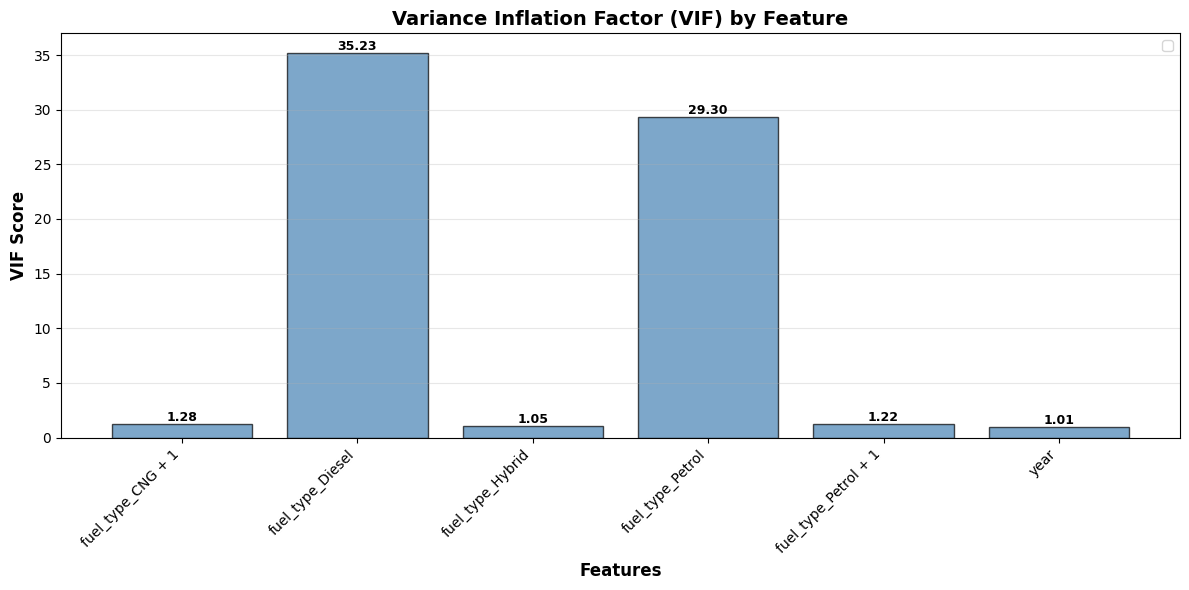

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Replace inf values with a large number for visualization
vif_clean = [v if not np.isinf(v) else np.nan for v in vif]
max_finite = max([v for v in vif_clean if not np.isnan(v)]) if any(not np.isnan(v) for v in vif_clean) else 100

# Replace NaN (previously inf) with max_finite * 1.2 for visual distinction
vif_plot = [v if not np.isnan(v) else max_finite * 1.2 for v in vif_clean]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(vif_plot)), vif_plot, color='steelblue', edgecolor='black', alpha=0.7)

# Color bars with inf values differently
for i, (v_orig, bar) in enumerate(zip(vif, bars)):
    if np.isinf(v_orig):
        bar.set_color('red')
        bar.set_alpha(0.5)

# Add column names as x-axis labels
ax.set_xticks(range(len(X.columns)))
ax.set_xticklabels(X.columns, rotation=45, ha='right')

# Add value labels on top of each bar
for i, (bar, v_orig) in enumerate(zip(bars, vif)):
    height = bar.get_height()
    label = 'inf' if np.isinf(v_orig) else f'{v_orig:.2f}'
    ax.text(bar.get_x() + bar.get_width()/2., height,
            label, ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Features', fontsize=12, fontweight='bold')
ax.set_ylabel('VIF Score', fontsize=12, fontweight='bold')
ax.set_title('Variance Inflation Factor (VIF) by Feature', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Correlation Analysis

I calculate the average of different correlation methods to have a stable correlation value of each column.

In [23]:
corr_methods = ["pearson", "kendall", "spearman"]
ignore_columns = []

corr_list = []

def describe_correlation(col: pd.Series):
  acc = 0
  temp_df = pd.DataFrame(col).drop(columns=ignore_columns).join(dataset["price"])
  print(temp_df.describe())
  for corr_method in corr_methods:
    corr_matrix = temp_df.corr(method=corr_method)
    corr = corr_matrix.iloc[0, 1]
    print(f"{corr_method}: {prec(corr)}")
    acc += corr

  avg = acc / len(corr_methods)
  print(f"avg: {prec(avg)}")
  print("\n")

  corr_list.append((col.name, avg))

In [24]:
ignore_cols = ["brand", "price", "petrol", "city"]
precision = 4

def prec(n, p=precision):
  return f"{n:.{p}f}"

for column in dataset.columns:
  if column in ignore_cols:
    # do nothing
    pass
  else:
    print(f"{column}")
    describe_correlation(dataset[column])

year
              year        price
count  1725.000000  1725.000000
mean      0.819056    13.808526
std       0.103468     0.870427
min       0.000000    11.042938
25%       0.741935    13.208543
50%       0.838710    13.681980
75%       0.903226    14.417091
max       1.000000    16.503358
pearson: 0.4381
kendall: 0.3331
spearman: 0.4483
avg: 0.4065


distance_travelled(kms)
       distance_travelled(kms)        price
count              1725.000000  1725.000000
mean                 10.628725    13.808526
std                   0.813970     0.870427
min                   5.860786    11.042938
25%                  10.275086    13.208543
50%                  10.799596    13.681980
75%                  11.163382    14.417091
max                  13.579789    16.503358
pearson: -0.2019
kendall: -0.1279
spearman: -0.1920
avg: -0.1739


brand_rank
        brand_rank        price
count  1725.000000  1725.000000
mean      0.477785    13.808526
std       0.244228     0.870427
min       0.000000

### Performing Correlation Analysis

Below I use three main correlation methods from Pandas library to see how proportional the values from each column is to quality of the wine.

For final comparison, I decided to average out the value of each correlation method to get a single number for each column. This can be done, since the values of each correlation method are quite close to each other and do not cancel out each other.

`brand_tier` (`brand_rank`) and `year` (`car_age`) values are, obviously, highly correlated to the price. A car having diesel or petrol engine also is an important factor when predicting the price. The distance travelled and state of the car (`new and less used`) are also correlated to the price.

City and less popular fuel types, in the context of this dataset, are not reflecting well on the car price.

In [27]:
sorted_corr = sorted(corr_list, key=lambda tup: abs(tup[1]), reverse=True)

print("Most correlated features (by absolute value):")
for col, num in sorted_corr:
  print(f"{col}: {num}")

Most correlated features (by absolute value):
brand_tier: 0.5503269482162492
fuel_type_Diesel: 0.4204928452250692
year: 0.4065050213440558
fuel_type_Petrol: -0.40603005571097933
car_age: -0.40244895786306617
inv_car_age: 0.380259022698868
brand_rank: -0.2677778016010004
inv_brand: 0.2567110326999044
new and less used: 0.25053964193104367
std_invrank: 0.248808867988032
best_buy1: -0.19986351095971358
distance below 30k km: 0.19091516931990196
distance_travelled(kms): -0.17393211564910072
best_buy2: 0.15705421967182046
inv_car_dist: 0.13779251418099547
std_invdistance_travelled: 0.1377734852754747
city_tier: -0.08144702574695145
fuel_type_CNG + 1: -0.07370453200139143
fuel_type_Petrol + 1: -0.05093952172477064
fuel_type_Hybrid: 0.021495752536230196


### Selecting Columns for Training

I dropped inverse columns, since they had a smaller correlation to the price and their values are already reflected in the original columns. Then, I filtered the columns which have correlation larger than a certain threshold (I ultimately chose the value of 1) to only train the model on important columns to avoid noise.

In [92]:
drop_cols = ["inv_car_age", "inv_brand", "inv_car_dist"]
threshold = 0.1

training_cols = [col for col, num in sorted_corr if abs(num) > threshold and not col in drop_cols]
training_cols

['brand_tier',
 'fuel_type_Diesel',
 'year',
 'fuel_type_Petrol',
 'car_age',
 'brand_rank',
 'new and less used',
 'std_invrank',
 'best_buy1',
 'distance below 30k km',
 'distance_travelled(kms)',
 'best_buy2',
 'std_invdistance_travelled']

### Splitting into Test / Train Dataset

In [93]:
from sklearn.model_selection import train_test_split

X = dataset[training_cols]
y = dataset['price']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the data
dataset[training_cols + ['price']].describe()

,brand_tier,fuel_type_Diesel,year,fuel_type_Petrol,car_age,brand_rank,new and less used,std_invrank,best_buy1,distance below 30k km,distance_travelled(kms),best_buy2,std_invdistance_travelled,price
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000
mean,0.406544,0.534493,0.819056,0.456812,0.508816,0.477785,0.209275,0.177658,0.035908,0.269565,0.617688,0.013133,0.013809,0.506479
std,0.424769,0.498953,0.103468,0.498276,0.151116,0.244228,0.406909,0.258034,0.076266,0.443863,0.105450,0.064041,0.038689,0.159407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.741935,0.000000,0.400000,0.295837,0.000000,0.029687,0.005747,0.000000,0.571874,0.000000,0.004524,0.396600
50%,0.584963,1.000000,0.838710,0.000000,0.516993,0.542578,0.000000,0.059821,0.014820,0.000000,0.639825,0.000000,0.006703,0.483304
75%,1.000000,1.000000,0.903226,1.000000,0.633985,0.680135,0.000000,0.190000,0.036640,1.000000,0.686953,0.000000,0.011631,0.617929
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### SciKitLearn Linear Regression

I train the model using Linear Regression model provided by the sklearn library

In [94]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [112]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = lr.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 0.007529320268614886
MAE: 0.06458089130444294
R^2: 0.7296929265863803


### Sigmoid's Linear Regression Implementation

I train the model using Linear Regression model provided by Sigmoid Handbook.

In [98]:
import numpy as np
import math

class SigmoidLinearRegression():
    """
    Initializes the Linear Regression model.
    It stores the self.params__ variable, which will be the
    weights that the model returns.
    """
    def __init__(self):
        self.params__ = None

    def gradientDescent(self, X, y, learning_rate=0.00001, iterations=500, batch_size=16):
        """
        This function applies the Stochastic Gradient Descent model to the dataset.

        :param X: numpy.ndarray - The matrix containing independent variable columns.
        :param y: numpy.ndarray - The target vector y.
        """
        # Add a column of ones for the constant term (bias)
        # We ensure y is reshaped to (rows, 1) to match X's dimensions
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        rows, cols = X.shape

        # Combine X and y to shuffle them together
        data = np.concatenate([X, y], axis=1)

        # Initial random guess for weights (w)
        w = np.random.random((cols, 1))

        for i in range(iterations):
            # Shuffle the rows of the data at the start of each iteration
            np.random.shuffle(data)

            y_it = data[:, -1].reshape((rows, 1))
            X_it = data[:, :-1]

            # Iterate through the batches
            for batch in range(math.ceil(rows / batch_size)):
                batch_start = batch * batch_size
                batch_end = min(batch_start + batch_size, rows)

                x_batch = X_it[batch_start:batch_end]
                y_batch = y_it[batch_start:batch_end]

                # Calculate the error (predictions - actual)
                prediction_error = np.matmul(x_batch, w) - y_batch

                # Update weights: w = w - learning_rate * (X_transpose * error)
                # Note: Dividing by batch size helps stabilize the learning rate
                gradient = np.matmul(x_batch.T, prediction_error)
                w -= learning_rate * gradient

        self.params__ = w
        return self

    def predict(self, X):
        """
        Predicts target values for the given input features.
        """
        # Add the column of ones for the constant term (bias)
        bias_column = np.ones((X.shape[0], 1))
        X = np.concatenate([X, bias_column], axis=1)

        return np.matmul(X, self.params__)

In [113]:
slr = SigmoidLinearRegression()

slr.gradientDescent(X_train.to_numpy(), y_train.to_numpy(), learning_rate=0.015)

In [114]:
y_pred = slr.predict(X_test.to_numpy())

print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 0.007592503555200221
MAE: 0.06483399884931894
R^2: 0.7274246090389482


### Final Results

Accuracy achieved from sklearn model and from Sigmoid model is almost the same. The fact that sklearn's model has a slighly better `R^2` accuracy is probably caused by learning rate optimization, for example by using learning rate decay.

MAE is about 6%, which is quite good, considering the low correlation level of the columns (not in the range of 0.5-0.8 required by the handbook).

`R^2` score indicates that the columns are decent at predicting the price, and that there is indeed some correlation between independent columns and the dependent one.

The accuracy of the model could be improved by engineering additional features based on the existing ones (e.g. economical index of the city, based on population, average income and other factors). Also, it is reasonable to assume that some columns that the model were trained on have introduced noise to the dataset and their exclusion from the training process could improve the model performance.